# FoPra: Maschinelles Lernen zur Klassifizierung von Sequenzdaten

**by Nick Lowack & Kien Nguyen**

<a id='0'>Table of Contents (ToC):</a>
* <a href='#1'>1. Frame the Problem and Look at the Big Picture</a>
* <a href='#2'>2. Get the Data</a>
* <a href='#3'>3. Explore the Data</a>
* <a href='#4'>4. Prepare the Data</a>
* <a href='#5'>5. Short-List Promising Models</a>
* <a href='#6'>6. Fine-Tune the System</a>
* <a href='#7'>7. Present the Solution</a>

### Param Playground

In [1]:
# Change which columns to remove here
ATTR_TO_REMOVE = ["Origin"]

# Change threshold for choosing top models here (value should be smaller than 1.0)
TOP_MODEL_THRESHOLD = 0.66

# Change size of the test dataset used for estimating generalization error here
TEST_SIZE = 8.0/40.0

# Change random state number here
SEED = 42

# Do we use stratified split or stratified shuffle split?
STRATIFIED_SHUFFLE=False

# Do we fix outlier?
FIX_OUTLIER=False

---
<a id='1'></a>
## 1. Frame the Problem and Look at the Big Picture

### 1.1 Define the objective in business terms

* *The aim of this project is to classify given Scaffolds either as Organelle or Non-Organelle.*

![Bezeichnung für die Grafik](OrganellarClassifier.png)

### 1.2 Frame the problem

* It is categorized as a Supervised, Batch, Model-based Learning Problem.

### 1.3 Choose evaluation metrics

* Precision
* Recall 
* F1-Score

### 1.4 Import necessary resources

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, make_scorer

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

<a href='#0'>Back to ToC</a>

---
<a id='2'></a>
## 2. Get the Data

### 2.1 Get and take a quick look at the data

In [3]:
# Read the data
df = pd.read_csv('Organelle_Classifier_4th.csv',sep=",", header="infer", index_col = 0)
df.head()

,tRNA,rRNA,rRNAp,Mito,Plastid,GC-dev,GC-out,GC,Len,MD,PD,Organelle,Origin
Scaffold,,,,,,,,,,,,,
CM017891.1,2,1,1,25,25,40.82,1,26.54,43.16,5.79,5.79,1,GCA_008330645.1
VLTN01000127.1,0,0,0,25,0,5.68,0,73.05,23.46,10.66,0.00,0,GCA_008330645.1
VLTN01000073.1,0,0,0,25,0,3.63,0,70.99,168.57,1.48,0.00,0,GCA_008330645.1
VLTN01000067.1,2,0,0,0,25,3.59,0,70.95,186.43,0.00,1.34,0,GCA_008330645.1
VLTN01000014.1,1,0,0,0,45,2.85,0,70.22,608.52,0.00,0.74,0,GCA_008330645.1


In [4]:
# Print a concise summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10849 entries, CM017891.1 to NC_053517.1
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tRNA       10849 non-null  int64  
 1   rRNA       10849 non-null  int64  
 2   rRNAp      10849 non-null  int64  
 3   Mito       10849 non-null  int64  
 4   Plastid    10849 non-null  int64  
 5   GC-dev     10849 non-null  float64
 6   GC-out     10849 non-null  int64  
 7   GC         10849 non-null  float64
 8   Len        10849 non-null  float64
 9   MD         10849 non-null  float64
 10  PD         10849 non-null  float64
 11  Organelle  10849 non-null  int64  
 12  Origin     10849 non-null  object 
dtypes: float64(5), int64(7), object(1)
memory usage: 1.2+ MB


In [5]:
# How many samples does each label class have in the data?
print(df["Organelle"].value_counts())

0    10809
1       40
Name: Organelle, dtype: int64


In [6]:
# What is the share (proportion) of each label class in the data?
print(df["Organelle"].value_counts()/len(df))

0    0.996313
1    0.003687
Name: Organelle, dtype: float64


### 2.2 Sample and put aside a test set

In [7]:
# Split the data using stratified sampling strategy
X = df.drop("Organelle", axis=1)
y = df["Organelle"]

if not STRATIFIED_SHUFFLE:
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=TEST_SIZE)
else:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=SEED)
    for train_index, test_index in sss.split(X, y):
        strat_train_set = df.iloc[train_index]
        strat_test_set = df.iloc[test_index]
    X_train = strat_train_set.drop("Organelle", axis=1)
    y_train = strat_train_set["Organelle"]
    X_test = strat_test_set.drop("Organelle", axis=1)
    y_test = strat_test_set["Organelle"]

In [8]:
# Check if the training data is evenly split
print(y_train.value_counts())
print(y_train.value_counts()/len(y_train))

0    8647
1      32
Name: Organelle, dtype: int64
0    0.996313
1    0.003687
Name: Organelle, dtype: float64


In [9]:
# Check if the test data is evenly split
print(y_test.value_counts())
print(y_test.value_counts()/len(y_test))

0    2162
1       8
Name: Organelle, dtype: int64
0    0.996313
1    0.003687
Name: Organelle, dtype: float64


<a href='#0'>Back to ToC</a>

---
<a id='3'></a>
## 3. Explore the Data

### 3.1 Create a copy of the data for exploration

In [10]:
scaffolds = df.copy()

### 3.2 Study characteristics of attributes

In [11]:
# Get statistics of numerical columns
scaffolds.describe()

,tRNA,rRNA,rRNAp,Mito,Plastid,GC-dev,GC-out,GC,Len,MD,PD,Organelle
count,10849.000000,10849.000000,10849.000000,10849.000000,10849.000000,10849.000000,10849.000000,10849.000000,10849.000000,10849.000000,10849.000000,10849.000000
mean,1.160383,2.995207,0.836759,10.978062,14.781823,5.575803,0.222970,41.404179,1237.222125,7.963515,12.744518,0.003687
std,29.592514,21.604973,31.586685,58.937200,113.189582,6.642307,0.416257,9.509727,12352.600329,45.934178,65.454652,0.060611
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.420000,0.200000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.510000,0.000000,37.050000,1.340000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,2.790000,0.000000,42.170000,1.900000,0.000000,0.000000,0.000000
75%,0.000000,4.000000,0.000000,1.000000,0.000000,6.620000,0.000000,44.070000,17.280000,0.060000,0.000000,0.000000
max,3007.000000,1659.000000,3265.000000,1745.000000,3365.000000,40.820000,1.000000,73.250000,474425.720000,1050.420000,1237.620000,1.000000


In [12]:
def plot_count_histogram_of(feature, df):
    """
    A function that plots histograms of the given feature for each label class.
    The x-axes in the first-row histograms depicts the value range of the given feature of Organelle scaffolds.
    """
    
    df_no = df[df["Organelle"]==0]
    df_yes = df[df["Organelle"]==1]
    
    
    df_yes_feature_min = df_yes[feature].min()
    df_yes_feature_max = df_yes[feature].max()
    width = (df_yes_feature_max-df_yes_feature_min)/len(df_yes[feature].unique())
#     nr_of_df_no_samples_in_df_yes_feature_range = len(df_no[(df_no[feature]<=df_yes_feature_max) & (df_no[feature]>=df_yes_feature_min)])
    
    
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 14))
    sns.histplot(data=df_no, x=feature, ax=axes[0][0], color='steelblue', binwidth=width)
    sns.histplot(data=df_yes, x=feature, ax=axes[0][1], color='darkorange', binwidth=width)
    sns.histplot(data=df_no, x=feature, ax=axes[1][0], color='steelblue', bins=50)
    
    
    xlabel = "Organelle Scaffolds's "+ feature + " range of values"
    
    axes[0][0].set_ylabel('#Scaffold')
    axes[0][0].set_xlabel(xlabel)
    axes[0][0].set_title('Non-Organelle')
    axes[0][0].axis(xmin=0,xmax=df_yes_feature_max)
#     axes[0][0].axis(ymin=0,
#                     ymax=max(df_no[(df_no[feature]<=df_yes_feature_max) & (df_no[feature]>=df_yes_feature_min)].value_counts().to_dict().values()))
    
    axes[0][1].set_ylabel('#Scaffold')
    axes[0][1].set_xlabel(xlabel)
    axes[0][1].set_title('Organelle')
    
    axes[1][0].set_ylabel('#Scaffold')
    axes[1][0].set_xlabel("The range of values of "+feature)
    axes[1][0].set_title('Non-Organelle')
    
    fig.suptitle(feature, fontsize=20)
    fig.tight_layout()

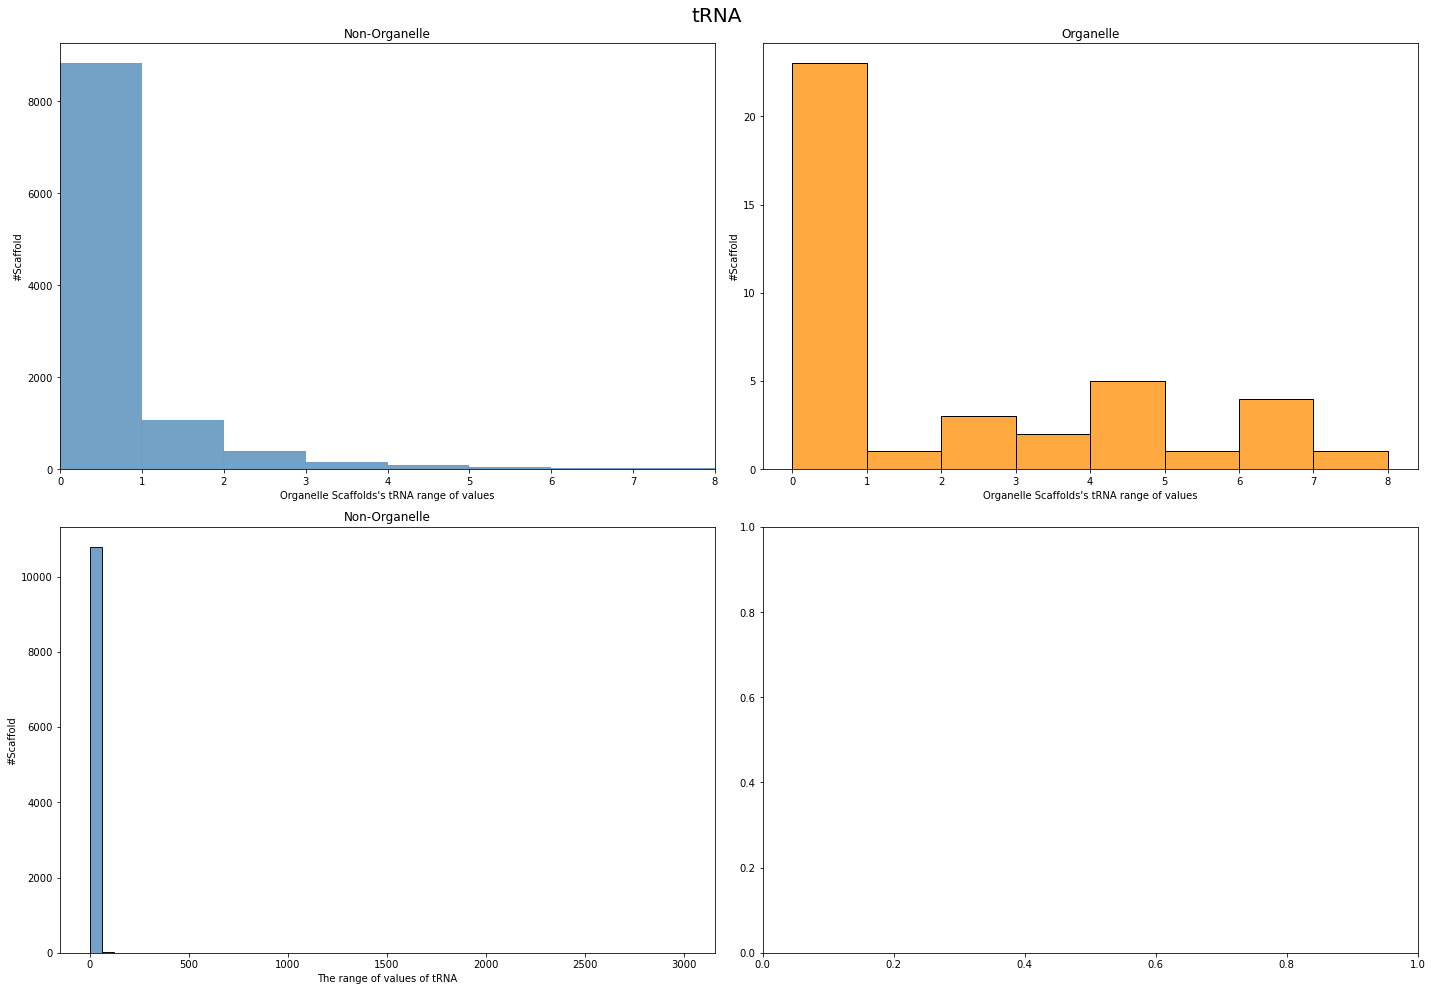

In [13]:
plot_count_histogram_of("tRNA", scaffolds)

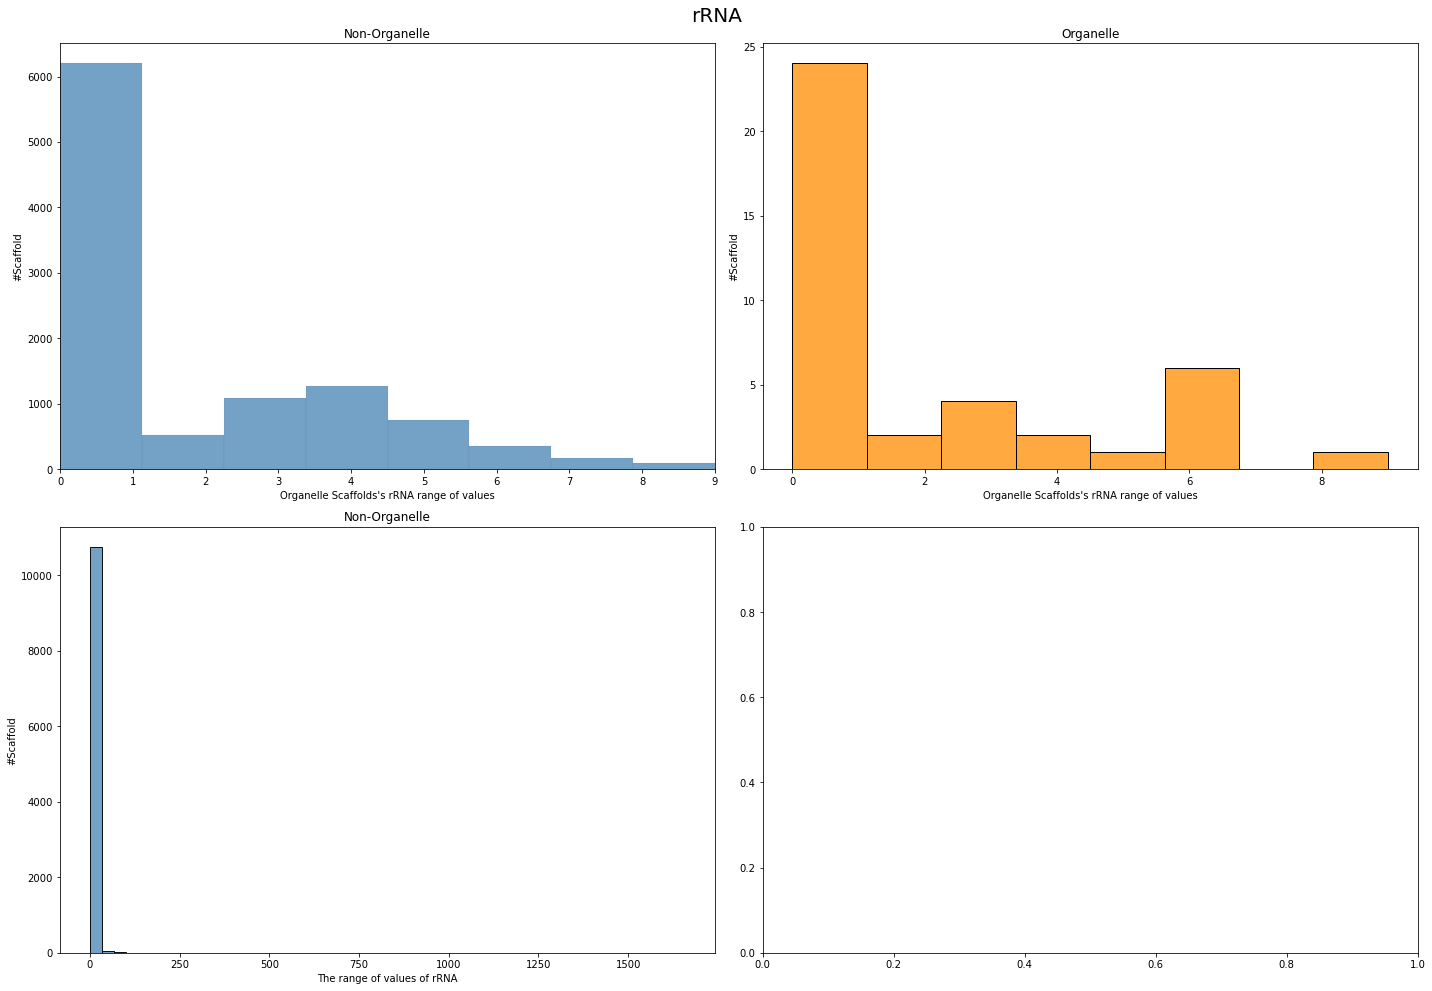

In [14]:
plot_count_histogram_of("rRNA", scaffolds)

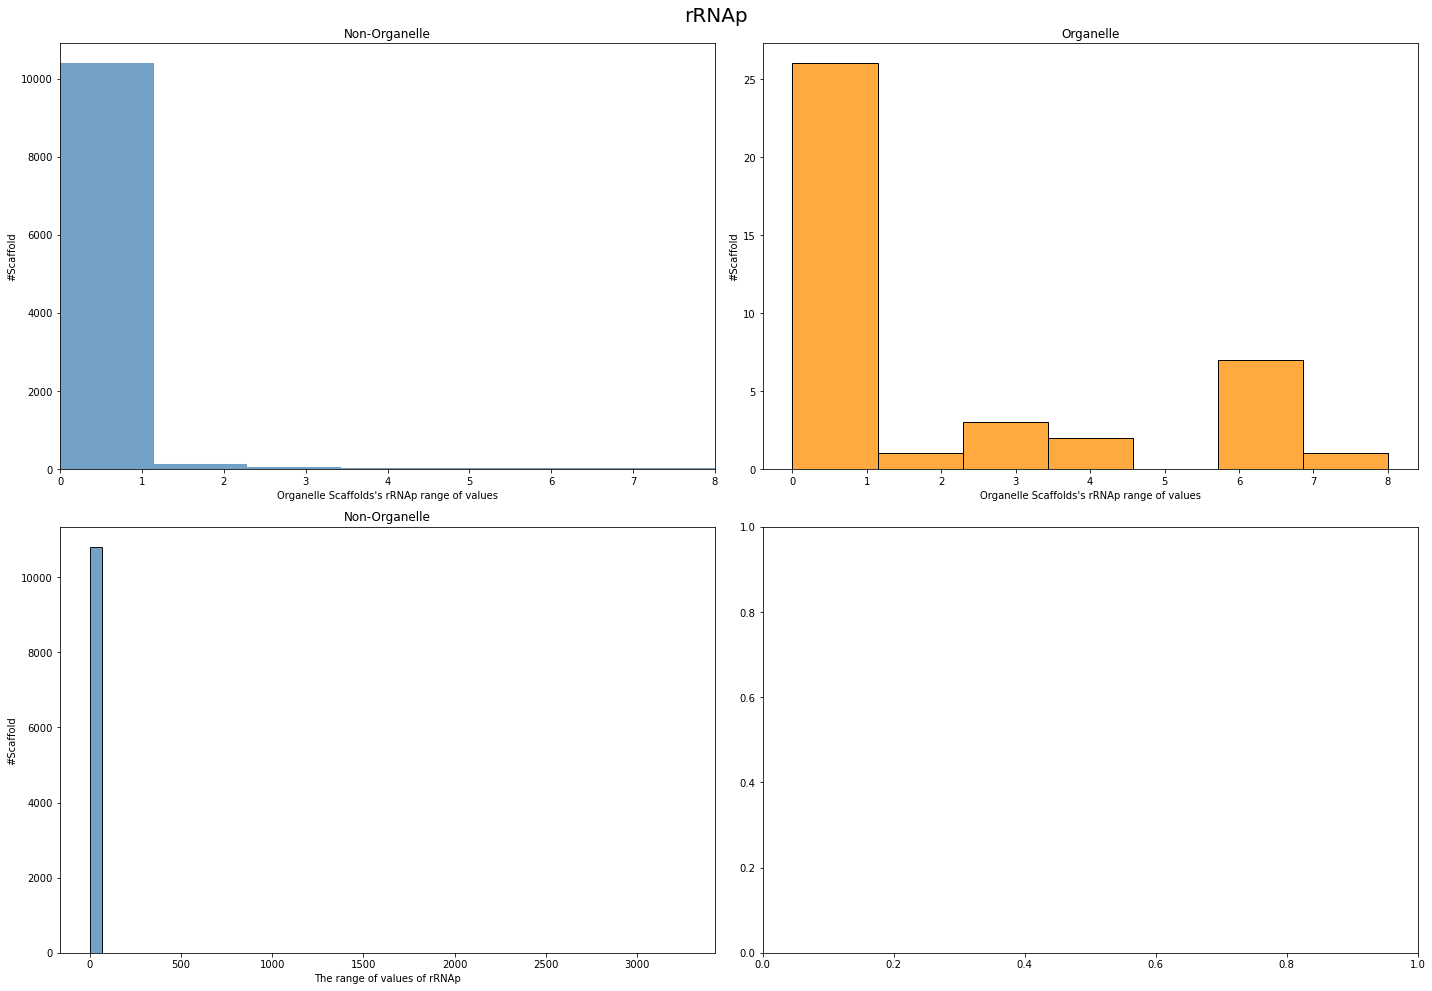

In [15]:
plot_count_histogram_of("rRNAp", scaffolds)

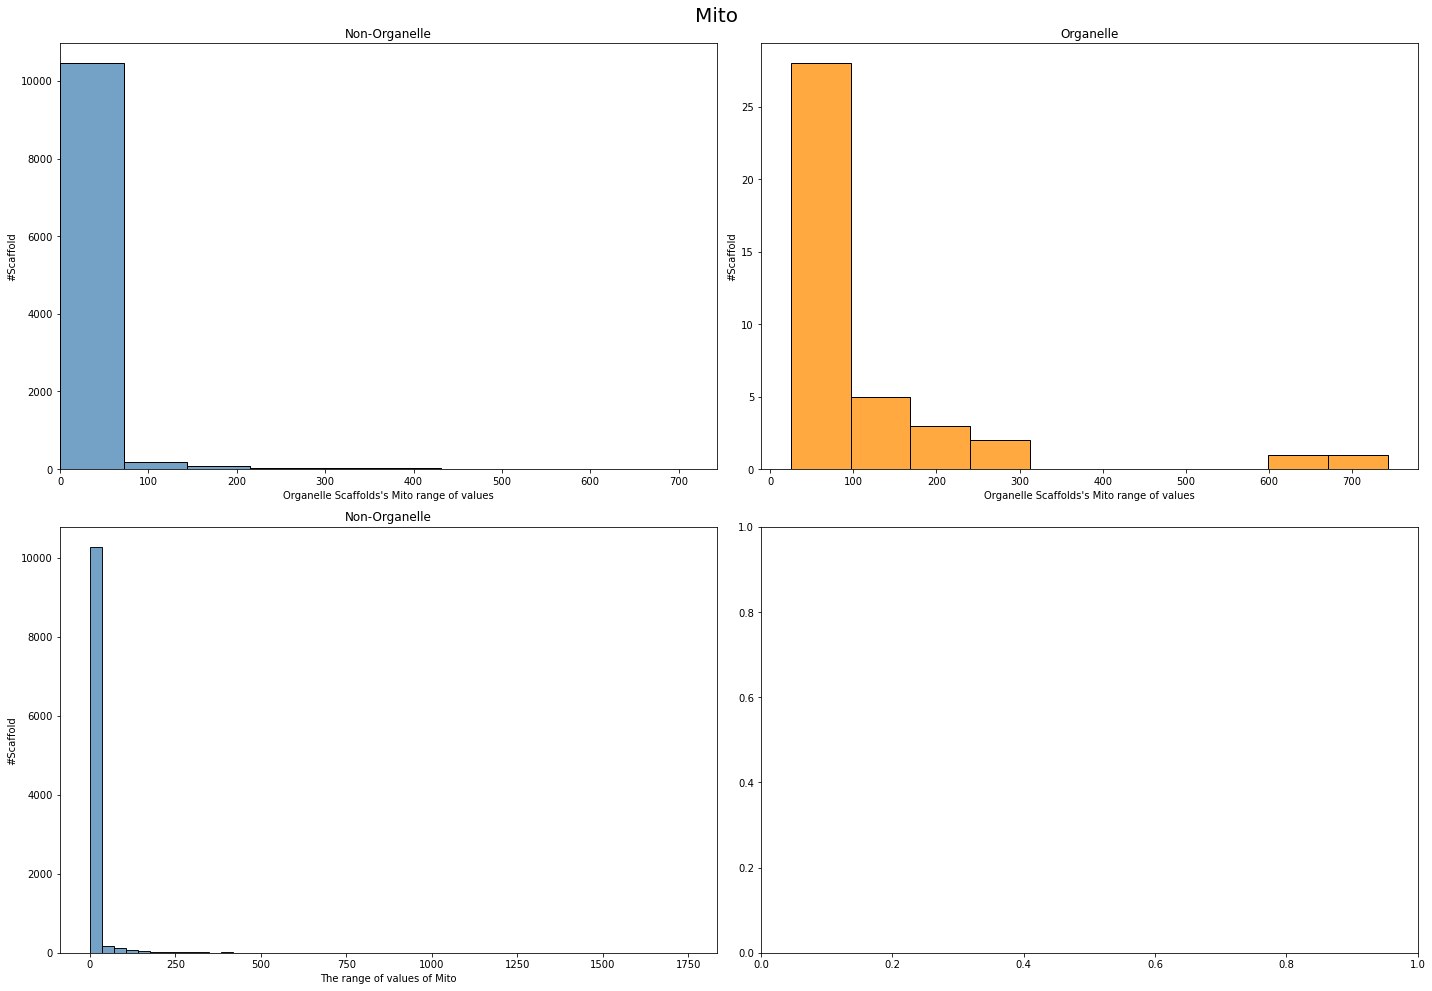

In [16]:
plot_count_histogram_of("Mito", scaffolds)

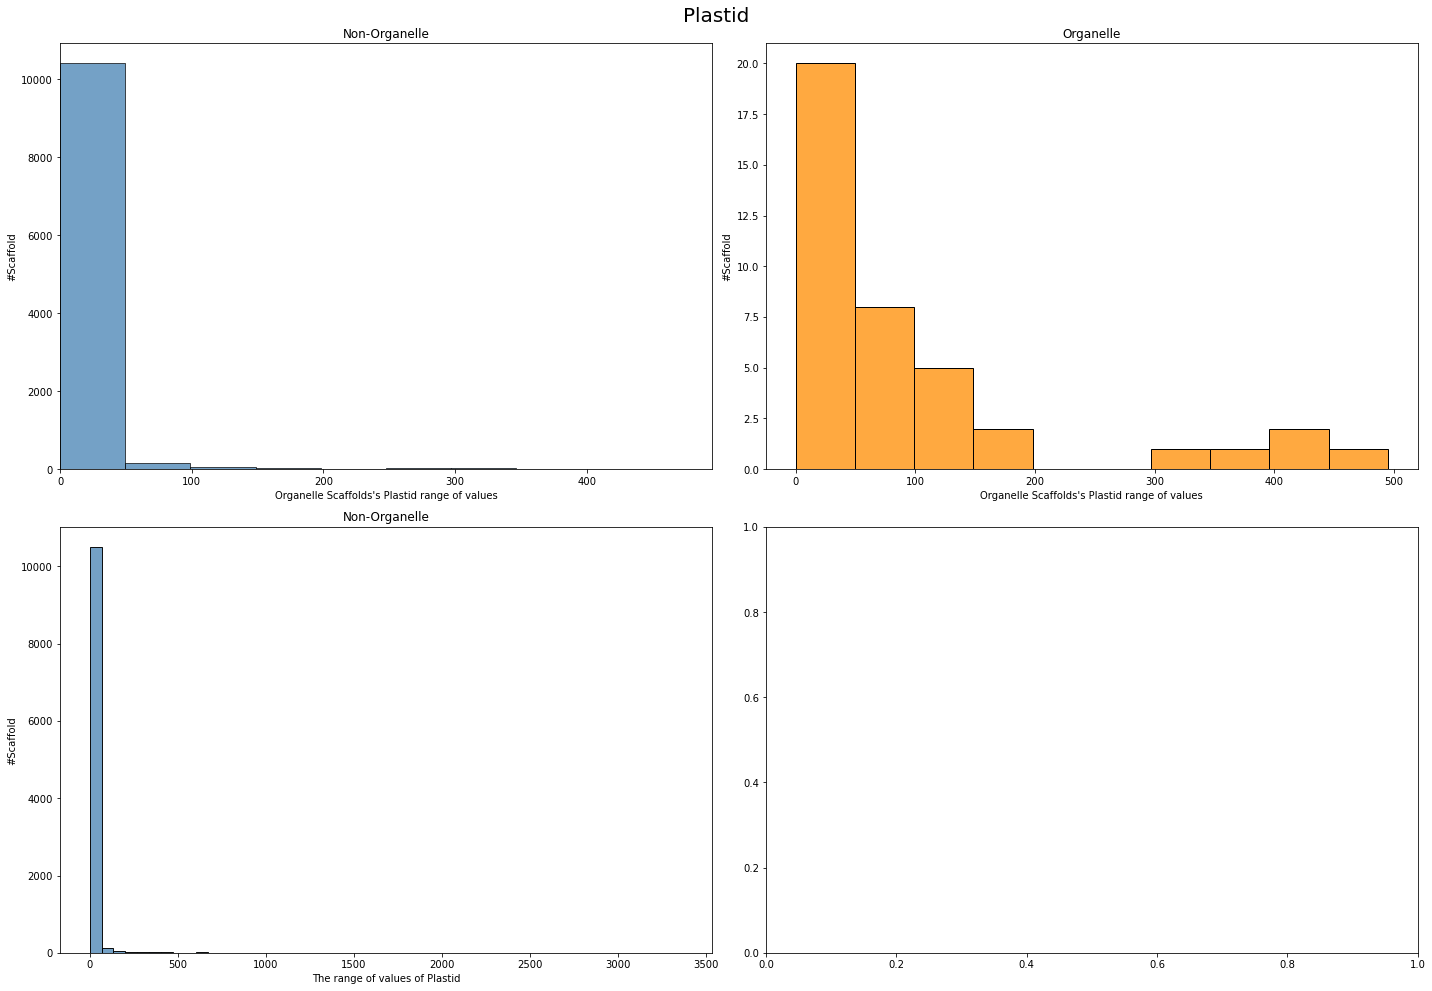

In [17]:
plot_count_histogram_of("Plastid", scaffolds)

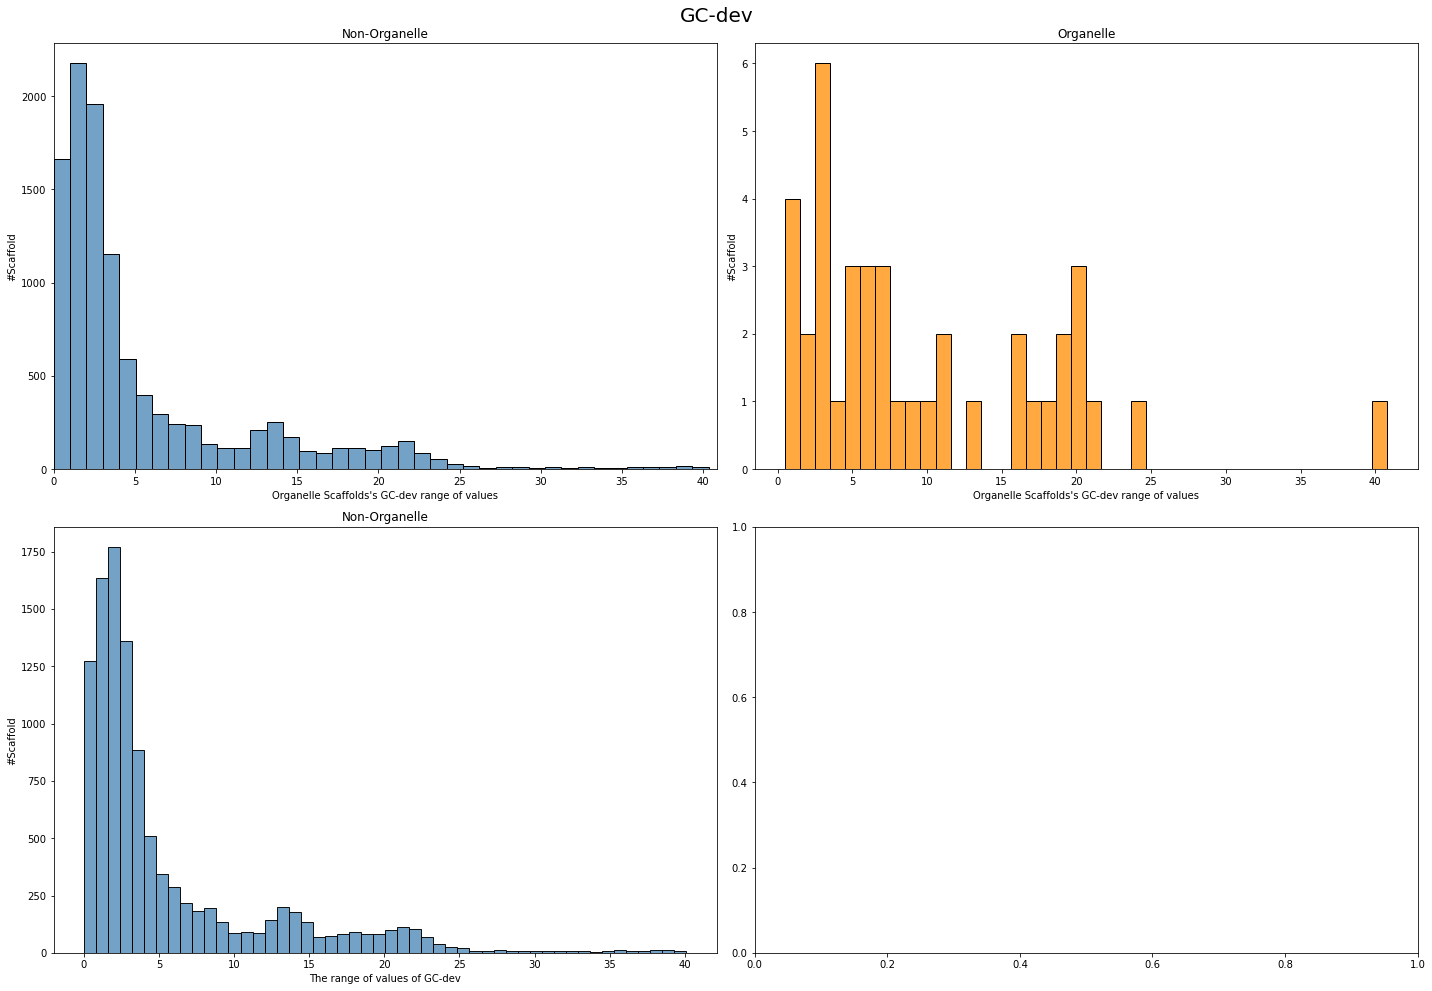

In [18]:
plot_count_histogram_of("GC-dev", scaffolds)

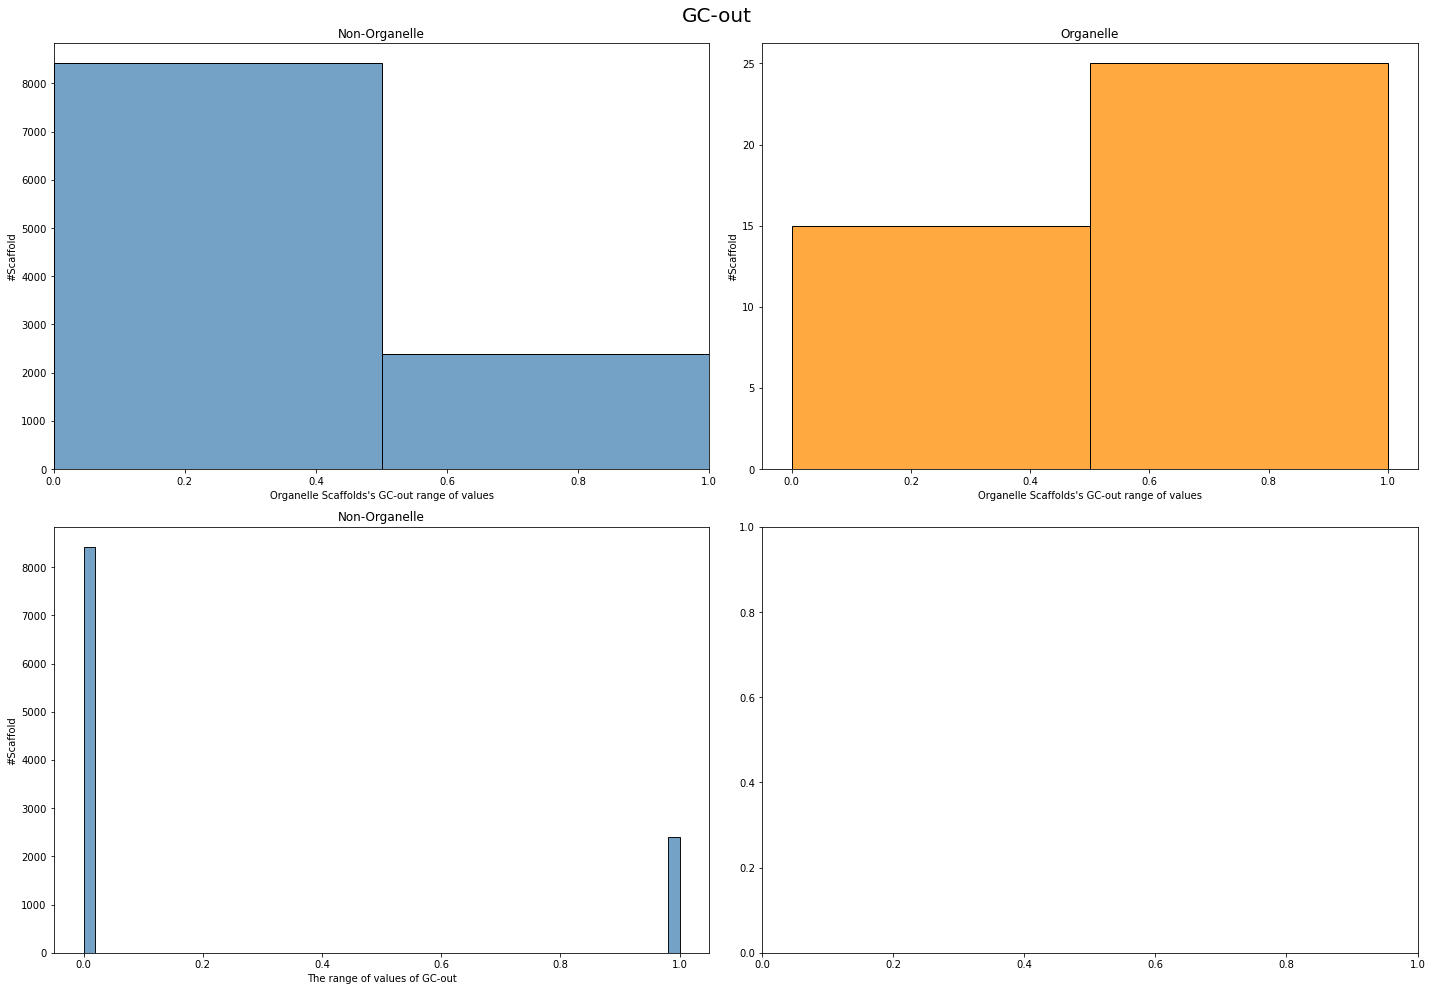

In [19]:
plot_count_histogram_of("GC-out", scaffolds)

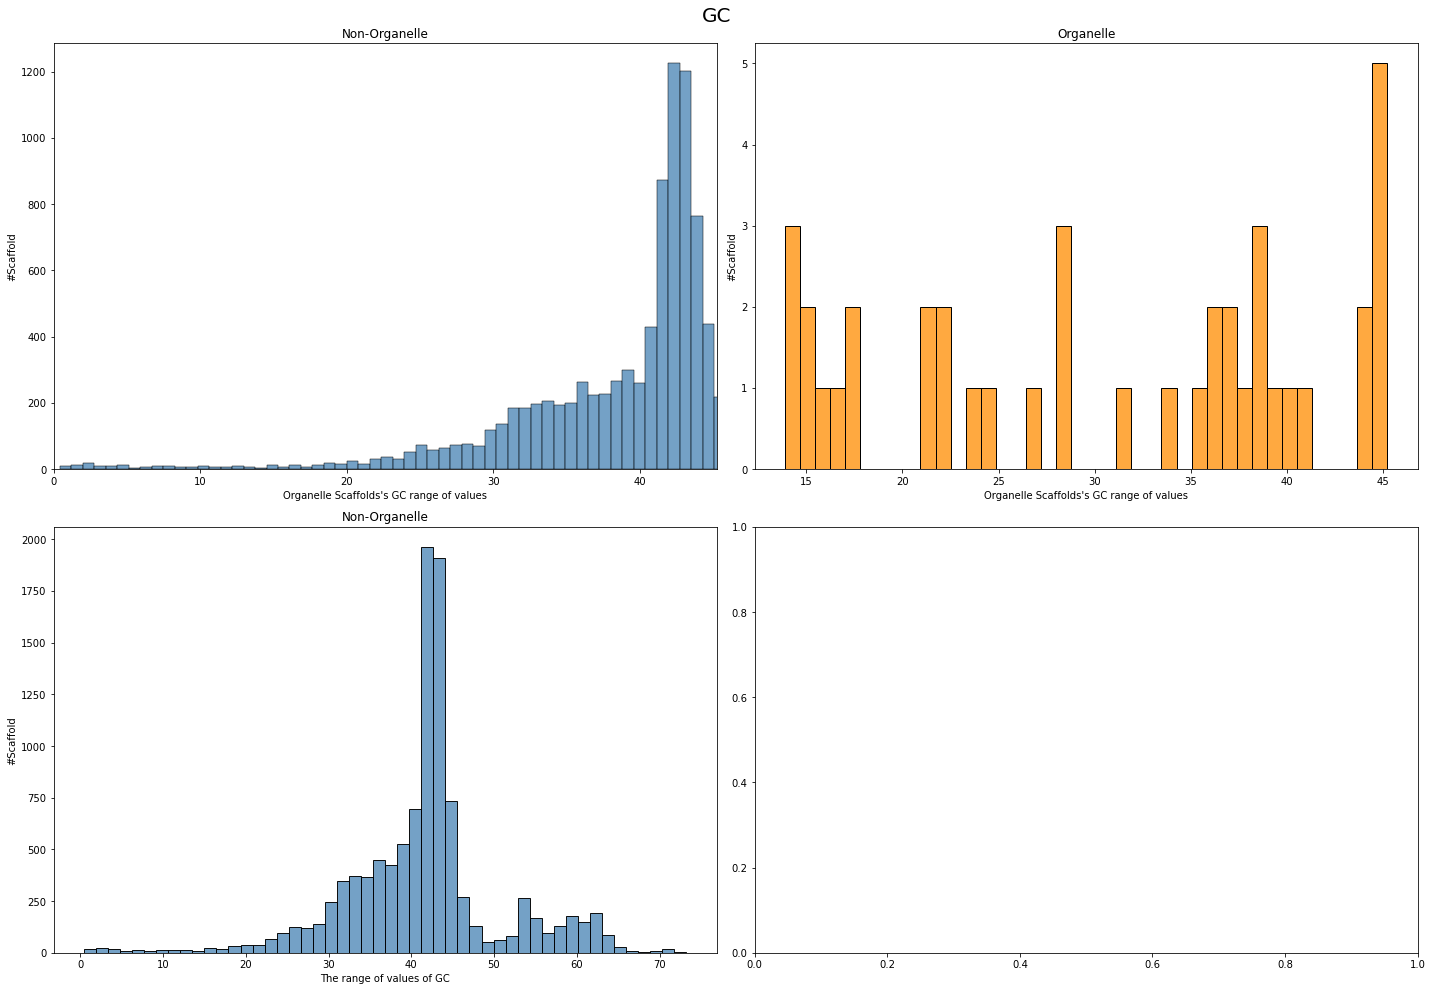

In [20]:
plot_count_histogram_of("GC", scaffolds)

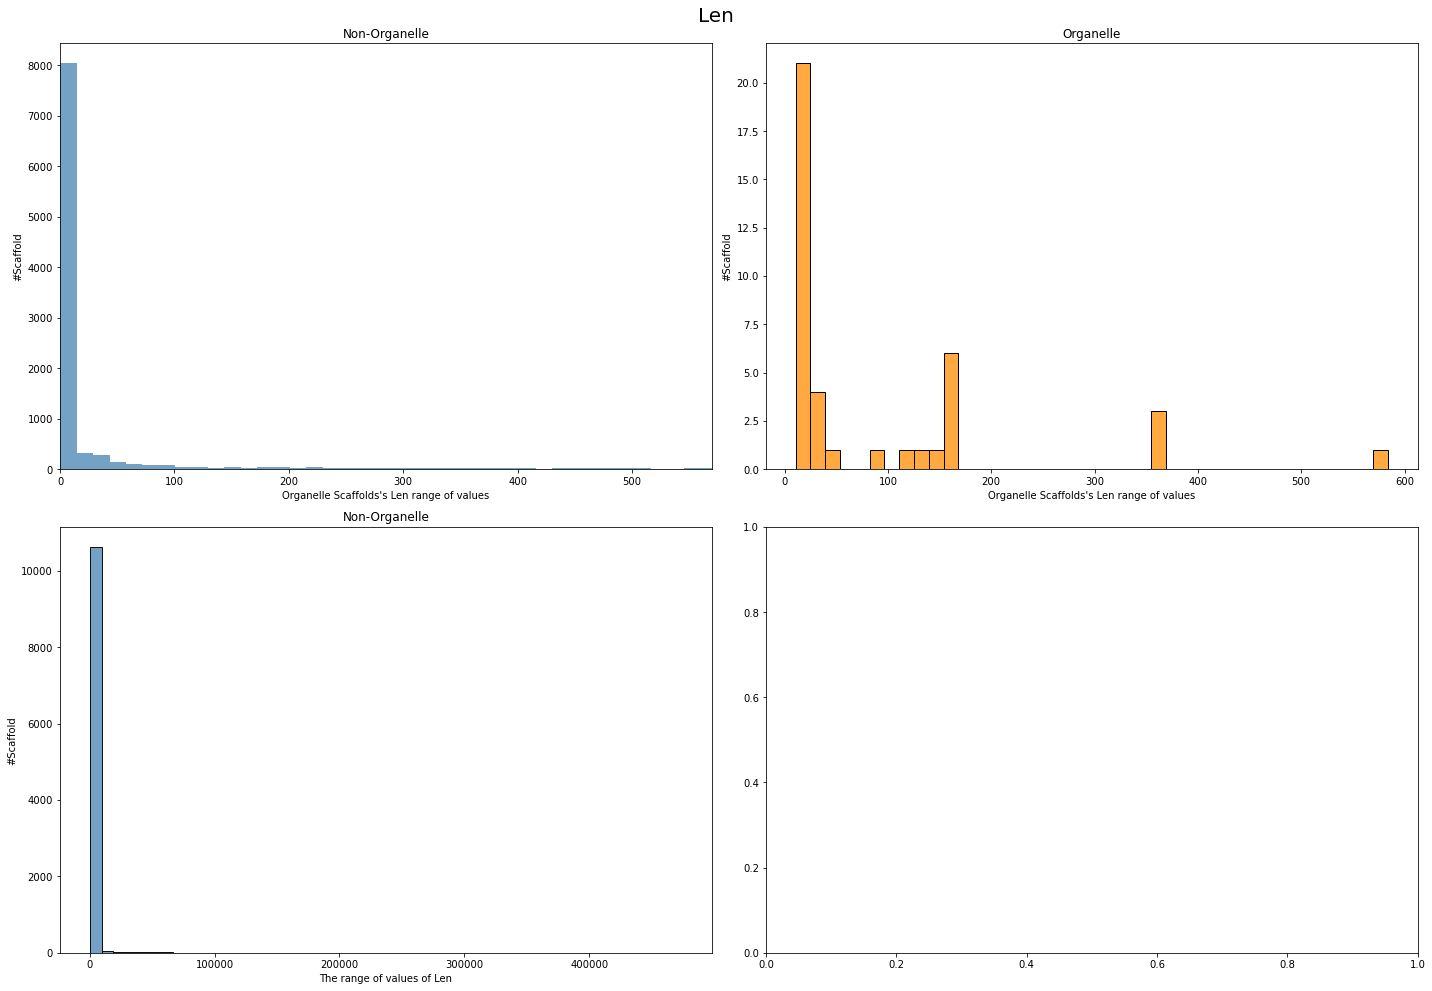

In [21]:
plot_count_histogram_of("Len", scaffolds)

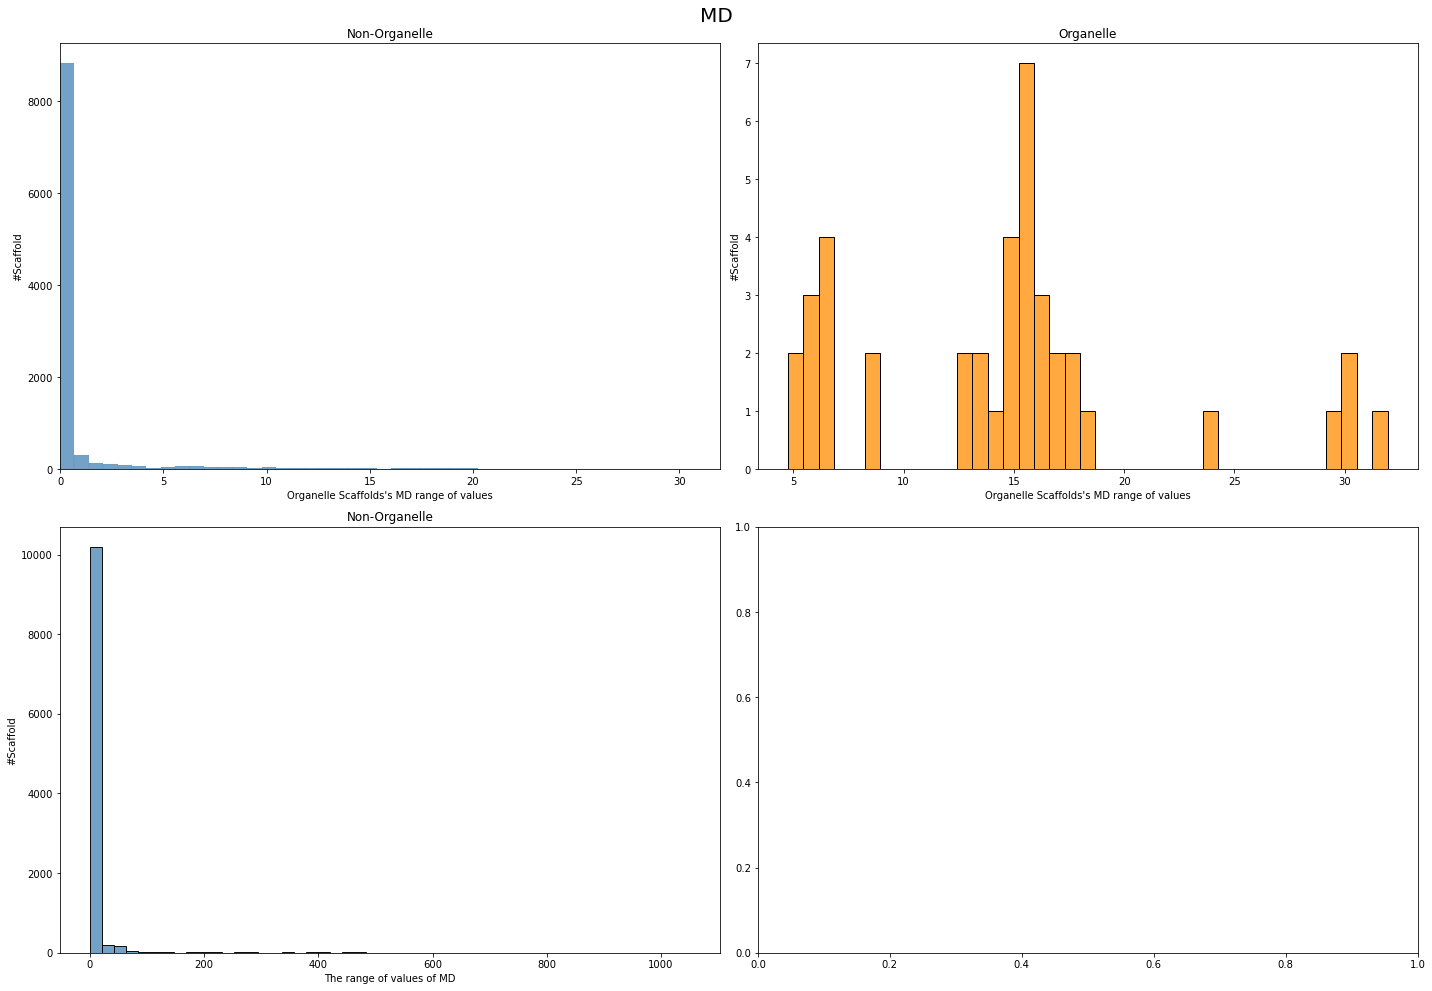

In [22]:
plot_count_histogram_of("MD", scaffolds)

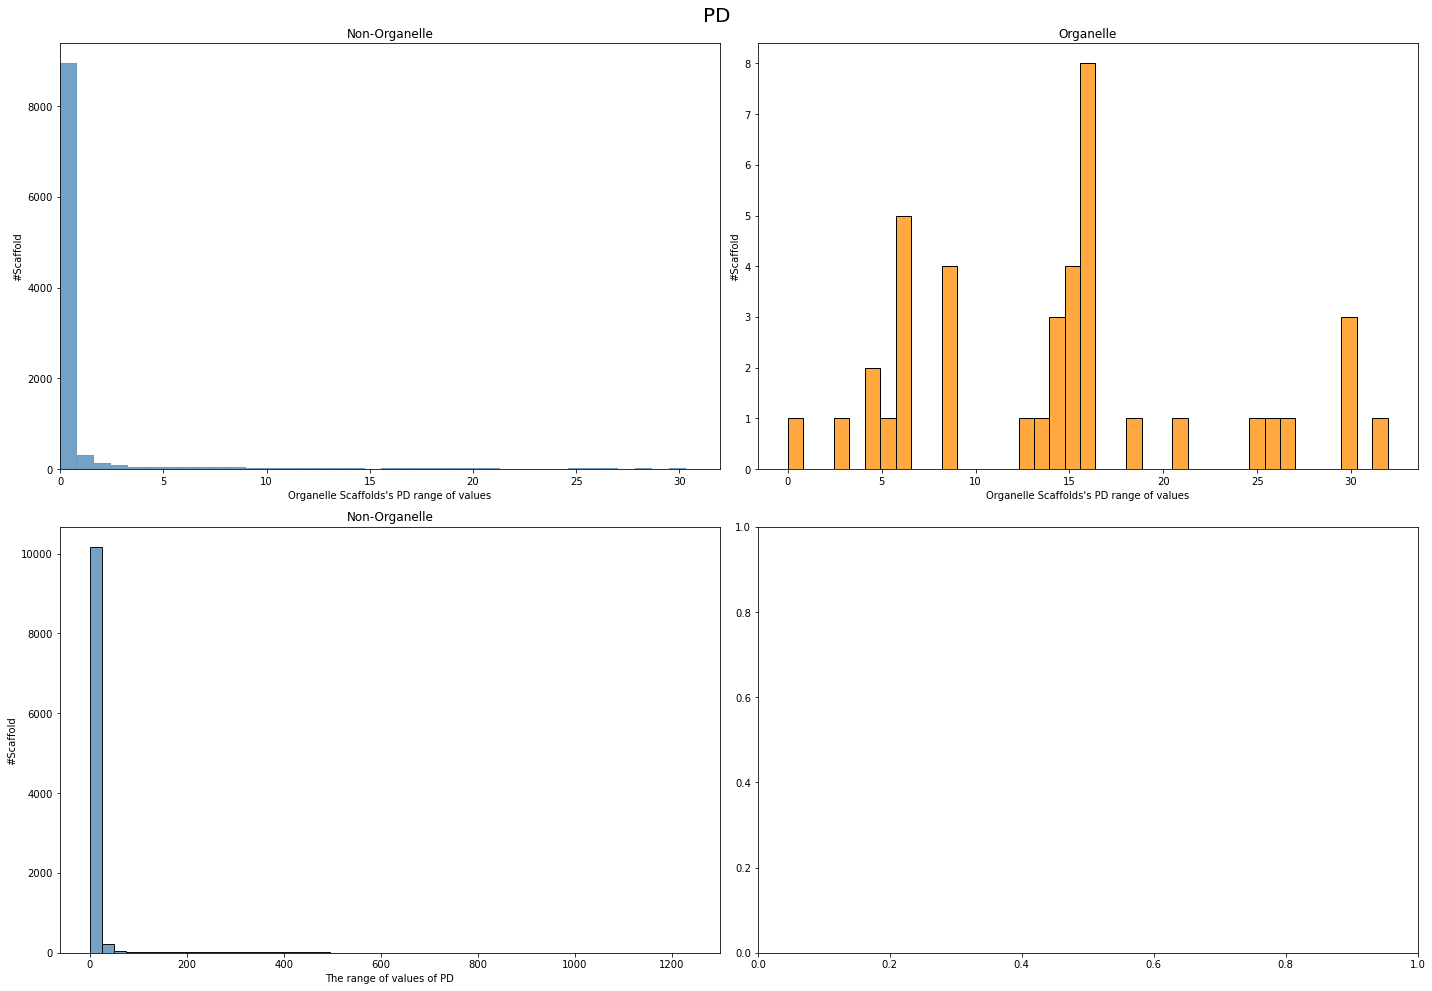

In [23]:
plot_count_histogram_of("PD", scaffolds)

### 3.3 Identify outliers and non-outliers

In [24]:
# Which scaffolds have maximum values in any of its features?
max_indices=scaffolds.drop(["Origin","Organelle"],axis=1).idxmax(axis=0)
scaffolds[scaffolds.index.isin(max_indices)]

,tRNA,rRNA,rRNAp,Mito,Plastid,GC-dev,GC-out,GC,Len,MD,PD,Organelle,Origin
Scaffold,,,,,,,,,,,,,
CM017891.1,2,1,1,25,25,40.82,1,26.54,43.16,5.79,5.79,1,GCA_008330645.1
NC_007115.7,3007,77,3265,524,161,0.33,0,36.57,78093.72,0.07,0.02,0,GCA_000002035.4
NC_050104.1,27,3,3,1745,1952,2.14,0,46.81,163004.74,0.11,0.12,0,GCA_902167145.1
NC_050096.1,61,7,5,1328,3365,2.17,0,46.84,308452.47,0.04,0.11,0,GCA_902167145.1
NC_044931.1,43,1659,203,838,593,11.26,1,22.52,18351.53,0.46,0.32,0,GCA_003576645.1
NW_017600905.1,1,0,0,0,0,32.37,1,73.25,0.50,0.00,0.00,0,GCF_000511025
NW_013650074.1,0,0,0,0,25,10.39,1,47.03,0.20,0.00,1237.62,0,GCF_000695525
NW_013644999.1,0,0,0,25,0,8.91,0,27.73,0.24,1050.42,0.00,0,GCF_000695525
NC_035108.1,184,49,2,1226,1219,0.66,0,37.88,474425.72,0.03,0.03,0,GCF_002204515


In [25]:
# What are the indices of the outliers and non-outliers?

OUTLIER_METHOD = "Z" # "Z" or "IQR"
IQR_CONSTANT = 3
Z_THRESHOLD = 3

def get_lower_upper_bounds(datacolumn, iqr_constant):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (iqr_constant * IQR)
    upper_range = Q3 + (iqr_constant * IQR)
    return lower_range, upper_range

def get_outlier_and_nonOutlier_indices(method, data):
    data_num = data.drop(["Len","Origin","Organelle","MD","PD"], axis=1)
    if method == "IQR":
        outlier_indices = pd.Index([])
        for col in data_num.columns:
            datacolumn = data_num[col]
            lower_bound, upper_bound = get_lower_upper_bounds(datacolumn, IQR_CONSTANT)
            outlier_indices = outlier_indices.union(data_num[(data_num[col] < lower_bound) | (data_num[col] > upper_bound)].index)
        non_outlier_indices = [x for x in df.index if x not in outlier_indices]    
    elif method == "Z":
        non_outlier_indices = data_num[(np.abs(stats.zscore(data_num)) < Z_THRESHOLD).all(axis=1)].index
        outlier_indices = [x for x in df.index if x not in non_outlier_indices]
    return outlier_indices, non_outlier_indices

outlier_indices, non_outlier_indices = get_outlier_and_nonOutlier_indices(OUTLIER_METHOD, scaffolds)

In [26]:
# How many Organelle and Non-Organelle scaffolds are left after the outliers are removed?
scaffolds[scaffolds.index.isin(non_outlier_indices)]["Organelle"].value_counts()

0    10428
1       34
Name: Organelle, dtype: int64

In [27]:
# Which of the outliers are Organelle Scaffolds?
scaffolds[scaffolds.index.isin(outlier_indices) & scaffolds["Organelle"]==1]

,tRNA,rRNA,rRNAp,Mito,Plastid,GC-dev,GC-out,GC,Len,MD,PD,Organelle,Origin
Scaffold,,,,,,,,,,,,,
CM017891.1,2,1,1,25,25,40.82,1,26.54,43.16,5.79,5.79,1,GCA_008330645.1
BK010421.1,4,2,2,652,314,7.50,1,44.79,367.81,17.73,8.54,1,GCA_000001735.2
AP000423.1,4,6,6,271,400,1.00,0,36.29,154.48,17.54,25.89,1,GCA_000001735.2
NC_034696.1,6,6,3,263,400,0.49,0,36.77,157.72,16.67,25.36,1,GCA_902201215.1
NC_001666.2,3,6,6,240,375,6.21,1,38.46,140.38,17.10,26.71,1,GCA_902167145.1
NC_007982.1,5,3,3,743,495,0.74,0,43.93,569.63,13.04,8.69,1,GCA_902167145.1


### 3.4 Study the correlations between attributes

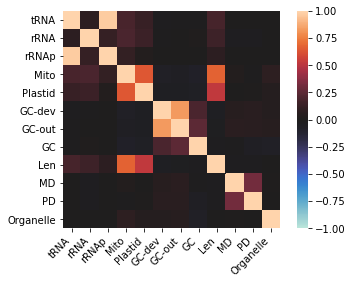

In [28]:
# Heatmap
ax = sns.heatmap(scaffolds.corr(), vmin=-1, vmax=1, center=0, square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

In [29]:
# Correlation coefficients of all columns to "Organelle" in descending order
scaffolds.corr()['Organelle'].sort_values(ascending=False)

Organelle    1.000000
Mito         0.091089
GC-out       0.058756
Plastid      0.042564
GC-dev       0.040273
MD           0.008847
rRNAp        0.001855
PD           0.001610
tRNA         0.001212
rRNA        -0.003084
Len         -0.005648
GC          -0.069938
Name: Organelle, dtype: float64

### 3.5 Document what you have learned

* **Irrelevantes Attribut**: Das Attribut "Origin" ist für die Klassifizierungsaufgabe irrelevant und sollte daher entfernt werden.
* **Ausreißer**: Die Entfernung der Ausreißer der ganzen Daten führt zu der Entfernung von 14 Organelle-Scaffolds.
* **Attribute mit niedrigen Korrelationen zur Spalte "Organelle"**: Obwohl die Korrelationskoeffizienten von "tRNA" und "rRNAp" trivial sind, kann man aus biologischen Hintergrund die beiden nicht entfernen.

### 3.6 Identify promising transformations to apply

* Drop "Origin"
* Fix Outliers in all columns except "Len" (Optional)
* Standardize all attributes

<a href='#0'>Back to ToC</a>

---
<a id='4'></a>
## 4. Prepare the Data

In [30]:
# Work on copies of the training data
scaffolds_predictors = X_train.copy()
scaffolds_label = y_train.copy()

### 4.1 Feature selection

In [31]:
# List attributes that need to be removed
attributes_to_remove = ATTR_TO_REMOVE

In [32]:
# Define a function that remove those attributes
def remove_attr(data, attr_to_remove=attributes_to_remove, remove_attr=True):
    if remove_attr:
        return data.drop(attr_to_remove, axis=1)
    else:
        return data

### 4.2 Data cleaning

In [33]:
# List all attributes that will be excluded when searching for outliers
excluded_attributes = ["Len"]

# define a threshold for calculating Z-Score
z_threshold = 3

In [34]:
# Define a function that replaces outlier values with those that are three Standard Deviations away from the Mean
def replace_outlier(val, mean, std, z_thresh):
    if val > mean + z_thresh*std:
        return mean + z_thresh*std 
    elif val < mean - z_thresh*std:
        return mean - z_thresh*std
    return val

In [35]:
# Define a function that fixes outliers (by replacing them with other statistical values)
# Since after removing "Origin" our data will contain only numerical attr, we do not need to filter out categorical attr
def fix_outliers(data, excluded_attr=excluded_attributes, fix_outlier=FIX_OUTLIER, z_thresh=z_threshold):
    if fix_outlier:
        data_filtered = data.drop(excluded_attr, axis=1)
        data_excluded = data[excluded_attr]
        for col in data_filtered.columns:
            mean = data_filtered[col].mean()
            std_dev = data_filtered[col].std(axis=0)
            data_filtered[col] = data_filtered[col].map(lambda x: replace_outlier(x, mean, std_dev, z_thresh))
        return data_filtered.merge(data_excluded, left_index=True, right_index=True)
    else:
        return data

### 4.3 Feature scaling

A function that standardizes features is already available from [```sklearn.preprocessing.StandardScaler()```](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

### 4.4 Transformation Pipeline

In [36]:
# Define a pipeline that transforms the predictor data after the steps (functions) listed above
# Activation Vector: 1-0-1
full_pipeline = Pipeline([
      ('attr_remover', FunctionTransformer(remove_attr, validate=False)),
      ('outlier_fixer', FunctionTransformer(fix_outliers, validate=False)),
      ('std_scaler', StandardScaler())
   ])

In [37]:
# Transform the training predictor data
scaffolds_predictors_prepared = full_pipeline.fit_transform(scaffolds_predictors)
scaffolds_predictors_prepared

array([[-5.73456962e-03, -2.89944112e-03, -2.59496776e-02, ...,
         3.04390712e-02, -1.74484368e-01, -1.89296867e-01],
       [-3.61379476e-02,  3.89016378e-02, -2.59496776e-02, ...,
        -9.93711504e-02, -1.74484368e-01, -1.95902042e-01],
       [-3.61379476e-02, -1.28302678e-01, -2.59496776e-02, ...,
        -9.94803983e-02, -1.74484368e-01,  1.04418093e+01],
       ...,
       [-3.61379476e-02, -1.28302678e-01, -2.59496776e-02, ...,
        -9.90256221e-02, -1.74484368e-01,  4.74446427e-01],
       [-3.61379476e-02, -1.28302678e-01, -2.59496776e-02, ...,
        -9.85877837e-02, -1.54844316e-01, -1.81770040e-01],
       [-3.61379476e-02, -1.28302678e-01, -2.59496776e-02, ...,
        -9.94007913e-02,  3.94352216e+00, -1.95902042e-01]])

In [38]:
# Dimensions of the data after transformation
scaffolds_predictors_prepared.shape

(8679, 11)

<a href='#0'>Back to ToC</a>

---
<a id='5'></a>
## 5. Shortlist Promising Models

### 5.1 Train many quick and dirty models from different categories

In [51]:
# Initialize a lookup dictionary for the models
models = {}

#### AdaBoost

In [52]:
ab_clf = AdaBoostClassifier(random_state=SEED)
models['AdaBoost'] = ab_clf

#### Bagging

In [53]:
bagging = BaggingClassifier(random_state=SEED)
models['Bagging'] = bagging

#### Decision Tree

In [54]:
tree_clf =  DecisionTreeClassifier(random_state=SEED)
models['Decision Tree'] = tree_clf

#### Extra Trees

In [55]:
extra_trees = ExtraTreesClassifier(random_state=SEED)
models['Extra Trees'] = extra_trees

#### Gradient Tree Boosting

In [56]:
gb_clf = GradientBoostingClassifier(random_state=SEED)
models['Gradient Boosting'] = gb_clf

#### Random Forest

In [57]:
forest_clf =  RandomForestClassifier(random_state=SEED)
models['Random Forest'] = forest_clf

### 5.2 Measure and compare their performance

* For each model, use stratified k-fold cross validation to split the given data and measure the performance of the model on the k folds
* The final score of each model will be the average of the performance measurements on all k folds

In [58]:
# Define a function that measures the performance of the given model on the k folds split from the given data
def performance_score(model, features, label, k_fold=5):
    precision_scores, recall_scores, f1_scores, predictions = [], [], [], []
    skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=SEED)
    X = features
    y = label.values
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predictions.append(y_predict)    
        precision_scores.append(precision_score(y_test,y_predict))
        recall_scores.append(recall_score(y_test,y_predict))
        f1_scores.append(f1_score(y_test,y_predict))
    return precision_scores, recall_scores, f1_scores, predictions

In [59]:
# Define a function that calculates the final score of each model
def model_scores(pos_models, features, label):
    precision_means, recall_means, f1_means = [], [], []
    for model in pos_models.values():
        precisions, recalls, f1s, preds = performance_score(model, features, label)
        precision_means.append(np.array(precisions).mean())
        recall_means.append(np.array(recalls).mean())
        f1_means.append(np.array(f1s).mean())
    result = pd.DataFrame({"Model":pos_models.keys(), "Precision":precision_means, "Recall":recall_means, "F1-Score":f1_means})
    return result

In [60]:
# Ignore warnings to have a clearer output
import warnings
warnings.filterwarnings('ignore')

# Measure performance of all models
measured_performance = model_scores(models, scaffolds_predictors_prepared, scaffolds_label)
# measured_performance

In [61]:
# Ranking models from best to worst using F1-score
measured_performance.sort_values(by="F1-Score", ascending=False)

,Model,Precision,Recall,F1-Score
3,Extra Trees,0.933333,0.642857,0.733333
0,AdaBoost,0.833333,0.590476,0.676923
1,Bagging,0.826190,0.557143,0.645934
5,Random Forest,0.960000,0.519048,0.641758
4,Gradient Boosting,0.753333,0.561905,0.629841
2,Decision Tree,0.559242,0.657143,0.589540


[Was bedeuten die obigen Warnungen?](https://stackoverflow.com/questions/54150147/classification-report-precision-and-f-score-are-ill-defined)

### 5.3 Get the top models

In [62]:
# Define a function that returns models whose performances measured in the given metric are higher than the given threshold 
def get_top_models(models, measured_performance, metric, threshold):
    top_performance = measured_performance[measured_performance[metric] > threshold]
    top_models = {}
    for name in top_performance["Model"].values:
        top_models[name] = models[name]
    return top_models

In [63]:
top_models = get_top_models(models, measured_performance, "F1-Score", TOP_MODEL_THRESHOLD)
top_models

{'AdaBoost': AdaBoostClassifier(random_state=42),
 'Extra Trees': ExtraTreesClassifier(random_state=42)}

<a href='#0'>Back to ToC</a>

---
<a id='6'></a>
## 6. Fine-Tune the System

### 6.1 Fine-tune the hyperparameters using cross-validation

* Treat your data transformation choices as hyperparameters, especially when you are not sure about them
* Unless there are very few hyperparameter values to explore, prefer random search over grid search

In [64]:
# Initialize a dict to store fine-tuned models
rnd_fine_tuned_models = {}
grid_fine_tuned_models = {}

# Define the parameters for Randomized & Grid Search
RND_SEARCH_N_ITER = 50
CV_FOLDS = 5
test_scorer = make_scorer(fbeta_score, beta=1)

In [65]:
# Define a function that prints out the scores (and hyperparameters) of all estimators in the randomized search
def print_cv_scores(cvres):
    for rank_score, mean_score, params in zip(cvres["rank_test_score"], cvres["mean_test_score"], cvres["params"]):
        print("Rank:", rank_score, "- Mean test score:", mean_score, "\nWith hyperparameters:", params)

#### AdaBoost

In [66]:
# RANDOMIZED SEARCH
if "AdaBoost" in top_models.keys():
    ab_param_distribs = {
            'base_estimator': [
                DecisionTreeClassifier()
                               ],
            'n_estimators': randint(low=50, high=801),
            'learning_rate': [0.5, 1., 1.5, 2.]
        }

    ab_rnd_search = RandomizedSearchCV(AdaBoostClassifier(random_state=SEED), 
                                    param_distributions=ab_param_distribs,
                                    n_iter=RND_SEARCH_N_ITER, 
                                    cv=CV_FOLDS, 
                                    scoring=test_scorer)
    ab_rnd_search.fit(scaffolds_predictors_prepared, scaffolds_label)
    print_cv_scores(ab_rnd_search.cv_results_)

    rnd_fine_tuned_models["AdaBoost"] = ab_rnd_search.best_estimator_ 

Rank: 1 - Mean test score: 0.5836052836052835 
With hyperparameters: {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 2.0, 'n_estimators': 421}
Rank: 1 - Mean test score: 0.5836052836052835 
With hyperparameters: {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 1.5, 'n_estimators': 676}
Rank: 1 - Mean test score: 0.5836052836052835 
With hyperparameters: {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 0.5, 'n_estimators': 683}
Rank: 1 - Mean test score: 0.5836052836052835 
With hyperparameters: {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 0.5, 'n_estimators': 84}
Rank: 1 - Mean test score: 0.5836052836052835 
With hyperparameters: {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 1.5, 'n_estimators': 774}
Rank: 1 - Mean test score: 0.5836052836052835 
With hyperparameters: {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 2.0, 'n_estimators': 171}
Rank: 1 - Mean test score: 0.5836052836052835 
With hyperpa

In [67]:
# GRID SEARCH
if "AdaBoost" in top_models.keys():
    ab_param_grid = {
            'base_estimator': [
                DecisionTreeClassifier()
                               ],
            'n_estimators': [50, 200, 350, 500, 650, 800],
            'learning_rate': [0.5, 1., 1.5, 2.]
        }

    ab_grid_search = GridSearchCV(AdaBoostClassifier(random_state=SEED), 
                                    param_grid=ab_param_grid,
                                    cv=CV_FOLDS, 
                                    scoring=test_scorer)
    ab_grid_search.fit(scaffolds_predictors_prepared, scaffolds_label)
    print_cv_scores(ab_grid_search.cv_results_)

    grid_fine_tuned_models["AdaBoost"] = ab_grid_search.best_estimator_ 

Rank: 1 - Mean test score: 0.5836052836052835 
With hyperparameters: {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 0.5, 'n_estimators': 50}
Rank: 1 - Mean test score: 0.5836052836052835 
With hyperparameters: {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 0.5, 'n_estimators': 200}
Rank: 1 - Mean test score: 0.5836052836052835 
With hyperparameters: {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 0.5, 'n_estimators': 350}
Rank: 1 - Mean test score: 0.5836052836052835 
With hyperparameters: {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 0.5, 'n_estimators': 500}
Rank: 1 - Mean test score: 0.5836052836052835 
With hyperparameters: {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 0.5, 'n_estimators': 650}
Rank: 1 - Mean test score: 0.5836052836052835 
With hyperparameters: {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 0.5, 'n_estimators': 800}
Rank: 1 - Mean test score: 0.5836052836052835 
With hyperpa

#### Bagging

In [68]:
# RANDOMIZED SEARCH
if "Bagging" in top_models.keys():
    bagging_param_distribs = {
            'base_estimator': [
                DecisionTreeClassifier()
                               ],
            'n_estimators': randint(low=10, high=801),
            'max_samples': [0.25, 0.5, 0.75, 1.],
            'max_features': [0.25, 0.5, 0.75, 1.],
            'bootstrap': [True, False]
        }

    bagging_rnd_search = RandomizedSearchCV(BaggingClassifier(random_state=SEED), 
                                    param_distributions=bagging_param_distribs,
                                    n_iter=RND_SEARCH_N_ITER, 
                                    cv=CV_FOLDS, 
                                    scoring=test_scorer
                                    )
    bagging_rnd_search.fit(scaffolds_predictors_prepared, scaffolds_label)
    print_cv_scores(bagging_rnd_search.cv_results_)

    rnd_fine_tuned_models["Bagging"] = bagging_rnd_search.best_estimator_ 

In [69]:
# GRID SEARCH
if "Bagging" in top_models.keys():
    bagging_param_grid = {
            'base_estimator': [
                DecisionTreeClassifier()
                               ],
            'n_estimators': [50, 250, 500, 800],
            'max_samples': [0.25, 0.5, 0.75, 1.],
            'max_features': [0.25, 0.5, 0.75, 1.],
            'bootstrap': [True, False]
    }

    bagging_grid_search = GridSearchCV(BaggingClassifier(random_state=SEED), 
                                    param_grid=bagging_param_grid,
                                    cv=CV_FOLDS, 
                                    scoring=test_scorer)
    bagging_grid_search.fit(scaffolds_predictors_prepared, scaffolds_label)
    print_cv_scores(bagging_grid_search.cv_results_)

    grid_fine_tuned_models["Bagging"] = bagging_grid_search.best_estimator_ 

#### Decision Tree

In [70]:
# RANDOMIZED SEARCH
if "Decision Tree" in top_models.keys():
    tree_param_distribs = {
            'criterion': ["gini","entropy"],
            'max_depth': randint(low=2, high=81),
            'min_samples_split': randint(low=2, high=8),
            'min_samples_leaf': randint(low=1, high=8)
        }

    tree_rnd_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=SEED), 
                                    param_distributions=tree_param_distribs,
                                    n_iter=RND_SEARCH_N_ITER, 
                                    cv=CV_FOLDS, 
                                    scoring=test_scorer
                                    )
    tree_rnd_search.fit(scaffolds_predictors_prepared, scaffolds_label)
    print_cv_scores(tree_rnd_search.cv_results_)

    rnd_fine_tuned_models["Decision Tree"] = tree_rnd_search.best_estimator_ 

In [71]:
# GRID SEARCH
if "Decision Tree" in top_models.keys():
    tree_param_grid = {
            'criterion': ["gini","entropy"],
            'max_depth': [5,10,20,40,80],
            'min_samples_split': [2,5,7],
            'min_samples_leaf': [1,4,7]
        }

    tree_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=SEED), 
                                    param_grid = tree_param_grid,
                                    cv=CV_FOLDS, 
                                    scoring=test_scorer)
    tree_grid_search.fit(scaffolds_predictors_prepared, scaffolds_label)
    print_cv_scores(tree_grid_search.cv_results_)

    grid_fine_tuned_models["Decision Tree"] = tree_grid_search.best_estimator_ 

#### Extra Trees

In [72]:
# RANDOMIZED SEARCH
if "Extra Trees" in top_models.keys():
    extra_param_distribs = {
            'n_estimators': randint(low=50, high=801),
            'max_depth': randint(low=2,high=81),
            'min_samples_split': randint(low=2, high=8),
            'min_samples_leaf': randint(low=1, high=8)
        }

    extra_rnd_search = RandomizedSearchCV(ExtraTreesClassifier(random_state=SEED), 
                                    param_distributions=extra_param_distribs,
                                    n_iter=RND_SEARCH_N_ITER, 
                                    cv=CV_FOLDS, 
                                    scoring=test_scorer
                                    )
    extra_rnd_search.fit(scaffolds_predictors_prepared, scaffolds_label)
    print_cv_scores(extra_rnd_search.cv_results_)

    rnd_fine_tuned_models["Extra Trees"] = extra_rnd_search.best_estimator_

Rank: 4 - Mean test score: 0.0 
With hyperparameters: {'max_depth': 60, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 174}
Rank: 4 - Mean test score: 0.0 
With hyperparameters: {'max_depth': 44, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 770}
Rank: 4 - Mean test score: 0.0 
With hyperparameters: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 188}
Rank: 4 - Mean test score: 0.0 
With hyperparameters: {'max_depth': 75, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 298}
Rank: 4 - Mean test score: 0.0 
With hyperparameters: {'max_depth': 35, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 520}
Rank: 4 - Mean test score: 0.0 
With hyperparameters: {'max_depth': 39, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 439}
Rank: 4 - Mean test score: 0.0 
With hyperparameters: {'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 535}
Rank: 4 - Mean test 

In [ ]:
# GRID SEARCH
if "Extra Trees" in top_models.keys():
    extra_param_grid = {
            'n_estimators': [50, 250, 500, 800],
            'max_depth': [5,10,20,40,80],
            'min_samples_split': [2,5,7],
            'min_samples_leaf': [1,4,7]
        }

    extra_grid_search = GridSearchCV(ExtraTreesClassifier(random_state=SEED), 
                                    param_grid = extra_param_grid,
                                    cv=CV_FOLDS, 
                                    scoring=test_scorer)
    extra_grid_search.fit(scaffolds_predictors_prepared, scaffolds_label)
    print_cv_scores(extra_grid_search.cv_results_)

    grid_fine_tuned_models["Extra Trees"] = extra_grid_search.best_estimator_ 

#### Gradient Boosting

In [ ]:
# RANDOMIZED SEARCH
if "Gradient Boosting" in top_models.keys():
    gb_param_distribs = {
            'n_estimators': randint(low=50, high=801),
            'max_depth': randint(low=2,high=81),
            'min_samples_split': randint(low=2, high=8),
            'min_samples_leaf': randint(low=1, high=8)
        }

    gb_rnd_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=SEED), 
                                    param_distributions=gb_param_distribs,
                                    n_iter=RND_SEARCH_N_ITER, 
                                    cv=CV_FOLDS, 
                                    scoring=test_scorer
                                    )
    gb_rnd_search.fit(scaffolds_predictors_prepared, scaffolds_label)
    print_cv_scores(gb_rnd_search.cv_results_)

    rnd_fine_tuned_models["Gradient Boosting"] = gb_rnd_search.best_estimator_

In [ ]:
# GRID SEARCH
if "Gradient Boosting" in top_models.keys():
    gb_param_grid = {
            'n_estimators': [50, 250, 500, 800],
            'max_depth': [5,10,20,40,80],
            'min_samples_split': [2,5,7],
            'min_samples_leaf': [1,4,7]
        }

    gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=SEED), 
                                    param_grid = gb_param_grid,
                                    cv=CV_FOLDS, 
                                    scoring=test_scorer)
    gb_grid_search.fit(scaffolds_predictors_prepared, scaffolds_label)
    print_cv_scores(gb_grid_search.cv_results_)

    grid_fine_tuned_models["Gradient Boosting"] = gb_grid_search.best_estimator_ 

#### Random Forest

In [ ]:
# RANDOMIZED SEARCH
if "Random Forest" in top_models.keys():
    forest_param_distribs = {
            'n_estimators': randint(low=50, high=801),
            'max_depth': randint(low=2,high=81),
            'min_samples_split': randint(low=2, high=8),
            'min_samples_leaf': randint(low=1, high=8)
        }

    forest_rnd_search = RandomizedSearchCV(RandomForestClassifier(random_state=SEED), 
                                    param_distributions=forest_param_distribs,
                                    n_iter=RND_SEARCH_N_ITER, 
                                    cv=CV_FOLDS, 
                                    scoring=test_scorer
                                    )
    forest_rnd_search.fit(scaffolds_predictors_prepared, scaffolds_label)
    print_cv_scores(forest_rnd_search.cv_results_)

    rnd_fine_tuned_models["Random Forest"] = forest_rnd_search.best_estimator_

In [ ]:
# GRID SEARCH
if "Random Forest" in top_models.keys():
    forest_param_grid = {
            'n_estimators': [50, 250, 500, 800],
            'max_depth': [5,10,20,40,80],
            'min_samples_split': [2,5,7],
            'min_samples_leaf': [1,4,7]
        }

    forest_grid_search = GridSearchCV(RandomForestClassifier(random_state=SEED), 
                                    param_grid = forest_param_grid,
                                    cv=CV_FOLDS, 
                                    scoring=test_scorer)
    forest_grid_search.fit(scaffolds_predictors_prepared, scaffolds_label)
    print_cv_scores(forest_grid_search.cv_results_)

    grid_fine_tuned_models["Random Forest"] = forest_grid_search.best_estimator_ 

### 6.2 Estimate the generalization error

Do NOT tweak your model after measuring the generalization error due to risk of overfitting the test set

In [ ]:
# Work on copies of the test data
test_scaffolds_predictors = X_test.copy()
test_scaffolds_label = y_test.copy()

# Transform the test predictor data
test_scaffolds_predictors_prepared = full_pipeline.fit_transform(test_scaffolds_predictors)

#### Performance of the top models

In [ ]:
for model_name, model in top_models.items():
    test_pred = model.predict(test_scaffolds_predictors_prepared)
    print("{}: F1-Score({}) - Precision({}) - Recall({}) ".format(model_name,
                                                                  f1_score(test_scaffolds_label, test_pred),
                                                                  precision_score(test_scaffolds_label, test_pred),
                                                                  recall_score(test_scaffolds_label, test_pred)))

#### Performance of the top models fine-tuned with Randomized Search

In [ ]:
for model_name, model in rnd_fine_tuned_models.items():
    test_pred = model.predict(test_scaffolds_predictors_prepared)
    print("{}: F1-Score({}) - Precision({}) - Recall({}) ".format(model_name,
                                                                  f1_score(test_scaffolds_label, test_pred),
                                                                  precision_score(test_scaffolds_label, test_pred),
                                                                  recall_score(test_scaffolds_label, test_pred)))

#### Performance of the top models fine-tuned with Grid Search

In [ ]:
for model_name, model in grid_fine_tuned_models.items():
    test_pred = model.predict(test_scaffolds_predictors_prepared)
    print("{}: F1-Score({}) - Precision({}) - Recall({}) ".format(model_name,
                                                                  f1_score(test_scaffolds_label, test_pred),
                                                                  precision_score(test_scaffolds_label, test_pred),
                                                                  recall_score(test_scaffolds_label, test_pred)))

<a href='#0'>Back to ToC</a>

---
<a id='7'></a>
## 7. Present the Solution